Choose the experment number - that will be used to determine the excel row
experiment_number = 1 - taking the first row in excel with respect to the date

In [1]:
experiment_number = 1

In [2]:
import My_functions as Mf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

c:\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
parent_folder = os.path.dirname(os.getcwd()) #on notebok only. in .py file its different
save_folder = os.path.join(parent_folder, 'output')
pic_folder = os.path.join(parent_folder, 'Picture', 'alot - PTV')
pic_folder = os.path.join(Mf.select_directory())



frames_per_second = Mf.read_data_from_cihx(pic_folder, return_number = True, return_int=True) # fps
dt = 1/frames_per_second
print('frame per second =', frames_per_second)
print('date of expirement : ', Mf.read_data_from_cihx(pic_folder, '<date>'))
round_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
print(f'Record number = {round_number}')

Mf.create_directory(save_folder)
Mf.copy_file(Mf.files_in_folder(pic_folder, 'cihx', True)[0], save_folder)


picture_list = Mf.find_pictures(pic_folder)
print(f't=0 is defined for frame number {int(os.path.splitext(os.path.basename(picture_list[0]))[0][-5:])}')
t_0_frame = int(os.path.splitext(os.path.basename(picture_list[0]))[0][-5:])

t_0_file_path = os.path.join(save_folder, 't_0.pkl')
Mf.save_pickle(t_0_file_path, [t_0_frame, frames_per_second])

frame per second = 60
date of expirement :  2024/2/22
Record number = 1
t=0 is defined for frame number 1
The file "t_0.pkl" has been saved at: c:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Python Thesis\Analysis\output


scaling factor from cihx

In [4]:
unit = Mf.read_data_from_cihx(pic_folder, '<distanceUnit>')
scaling_factor = 1/Mf.read_data_from_cihx(pic_folder, '<sizeOfPixel>', return_number = True) #[pixel/mm]
if 'mm' in unit:
    scaling_factor *= 1000
scaling_factor #[pixel/m]

3006.614552014432

choose origin

In [5]:
origin = [0, 1024]
# origin = Mf.choose_origin_napari(Mf.find_pictures(pic_folder)[0])

all the files in the directory

In [6]:
sphere_location_pixel = Mf.track_object_series(pic_folder, fft=True, read_from_pickle_if_possible=False,
												image_number = 6414,
												sphere_location = [478, 932],
												Object_data = [[432, 888], [432, 983], [524, 983], [524, 888]],
												PTV_data = [[384, 0], [384, 1024], [589, 1024], [589, 0]])

use arrow keys for fine adjustments, toggle Points visability on and off to see changes 
Select the sphere, the area for PTV and the image number 
important!!! make sure the slider is on the relevant frame 
Change the contrasnt to enable manual high_pass_filter
												image_number = 2638,
												sphere_location = [478, 932],
												Object_data = [[432, 888], [432, 983], [524, 983], [524, 888]],
												PTV_data = [[384, 0], [384, 1024], [589, 1024], [589, 0]])


In [7]:
sphere_location_meter = Mf.transform_coordinates_physical(sphere_location_pixel, pic_folder, scaling_factor, origin_point=origin)

from pixel to meter

2705 2705


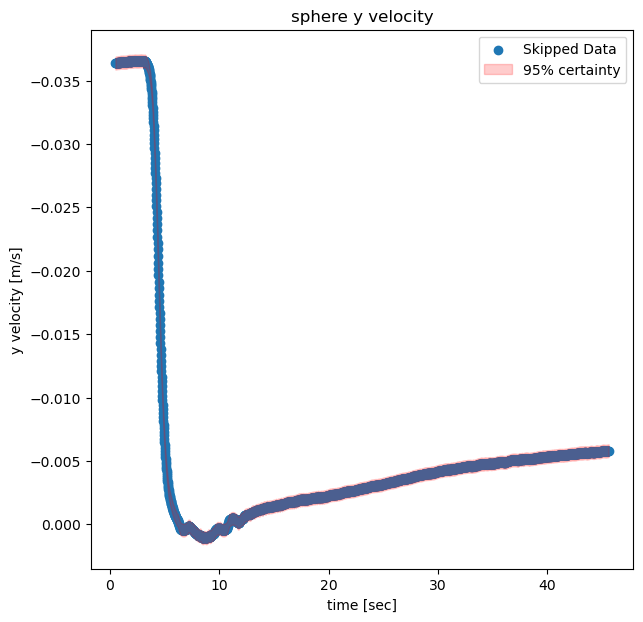

2768 2768


In [8]:
wanted_velocity_uncertainty = 0.001/2 #[m/s]
location_uncertainty_pixel = 2 #[pixel]
neighboring_points = Mf.neighboring_points_from_velocity_acceptable_error(velocity_acceptable_error = wanted_velocity_uncertainty, window_size = 0.3, dt = dt, location_uncertainty_pixel = location_uncertainty_pixel)
# y_location_meter_cutted, y_velocity_meter_cutted = Mf.calc_velocity_least_squares_lines(sphere_location_meter[:,1], dt=dt, velocity_acceptable_error = wanted_velocity_uncertainty, location_uncertainty_pixel = location_uncertainty_pixel)
# y_location_meter_cutted = Mf.location_with_respect_to_velocity(sphere_location_meter[:,1], dt=dt, velocity_acceptable_error=wanted_velocity_uncertainty, location_uncertainty_pixel = location_uncertainty_pixel)
y_location_meter_cutted, y_times_cutted, y_velocity_meter_cutted = Mf.calc_velocity_least_squares_lines_with_times(sphere_location_meter[:,1], dt=dt, neighboring_points=neighboring_points)
postivie_vel = -y_velocity_meter_cutted

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('sphere y velocity')
plt.scatter(y_times_cutted, y_velocity_meter_cutted, label='Skipped Data')
plt.fill_between(y_times_cutted, y_velocity_meter_cutted + wanted_velocity_uncertainty, y_velocity_meter_cutted - wanted_velocity_uncertainty, color='red', alpha=0.2, label='95% certainty')
print(len(y_location_meter_cutted), len(y_location_meter_cutted))


ax.set_xlabel('time [sec]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()
# plt.savefig(os.path.join(save_folder, 'sphere velocity PTV.svg'), transparent=True, bbox_inches='tight')

velocitys_meter = Mf.full_list_from_interpolate_between_points(y_location_meter_cutted, y_velocity_meter_cutted, sphere_location_meter[:,1])
print(len(velocitys_meter), len(sphere_location_meter[:,1]))

Acceleration

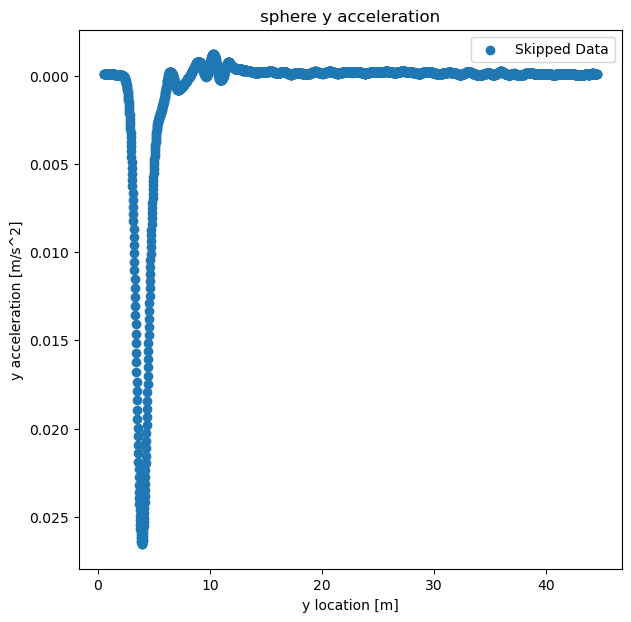

In [9]:
y_location_acccel_cutted, y_times_acccel_cutted, y_accel_meter_cutted = Mf.calc_acceleration_least_squares_lines_with_times(y_location_meter_cutted, y_velocity_meter_cutted, dt=dt, neighboring_points = neighboring_points)
y_accel_meter_cutted = np.array(y_accel_meter_cutted)


fig, ax = plt.subplots(figsize=(7, 7))
plt.title('sphere y acceleration')
plt.scatter(y_times_acccel_cutted, y_accel_meter_cutted, label='Skipped Data')


ax.set_xlabel('y location [m]')
ax.set_ylabel('y acceleration [m/s^2]')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [10]:
row_number = experiment_number - 1
experiment_date = Mf.read_data_from_cihx(pic_folder, '<date>')
upper_viscosity, lower_viscosity, upper_density, lower_density, Interface_thickness, sphere_diameter, sphere_rho, sphere_type, Interface_center \
      = Mf.load_data_for_demintionless_number(experiment_date = experiment_date, row_number=row_number)

Density

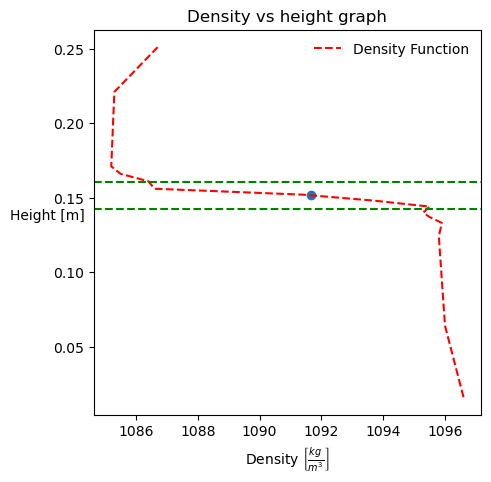

In [11]:
import My_functions as Mf
import numpy as np
import matplotlib.pyplot as plt
# y_loccccc, densityccccc = Mf.load_density_profile_from_excel(date = '22-02-2024')
y_loccccc, densityccccc = Mf.load_density_profile_from_excel(date=Mf.convert_date(Mf.read_data_from_cihx(save_folder, '<date>')))

rho_function = Mf.create_callable_function_of_data(y_loccccc, densityccccc)

y_loccccc2 = np.array(y_loccccc)
densityccccc2 = np.array(densityccccc)

# x_domain = np.linspace(0, 0.6, 1000)
# Interface_thickness = Mf.find_interface_thickness_callable(x_domain, rho_function)

Interface_height = Mf.find_average_density_location(y_loccccc2, densityccccc2)


interface_lower_location = Interface_height - Interface_thickness/2
interface_width = Interface_thickness


fig, ax = plt.subplots(figsize=(5,5))

plt.title('Density vs height graph')
plt.plot(densityccccc2, y_loccccc2, '--', label='Density Function', color='red')
plt.xlabel(r'Density $ \left[ \frac {kg} {m^3} \right]$', rotation=0)
ylabel = plt.ylabel('Height [m]', rotation=0)
plt.scatter(rho_function(Interface_height), Interface_height)

# Interface
plt.axhline(Interface_height-Interface_thickness/2, linestyle='--', color='green')
plt.axhline(Interface_height+Interface_thickness/2, linestyle='--', color='green')
plt.legend(fancybox=True, framealpha=0)
plt.show()

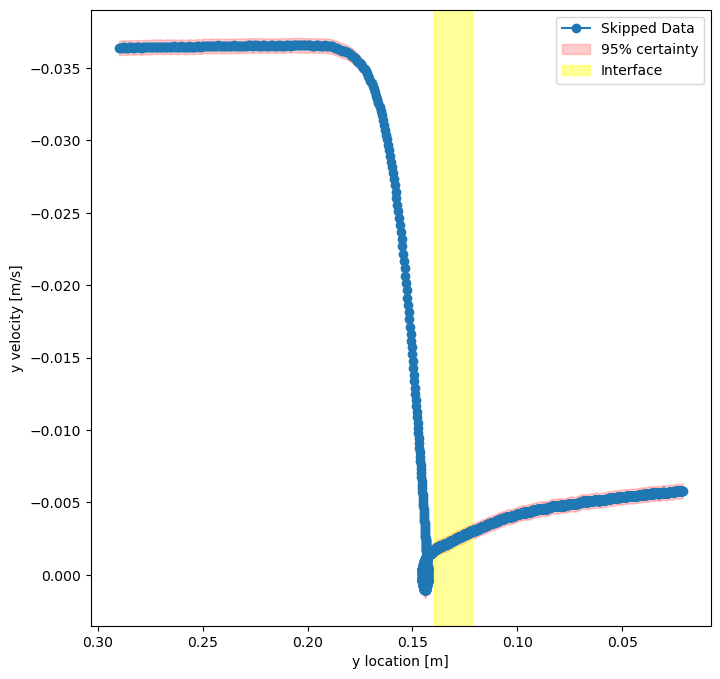

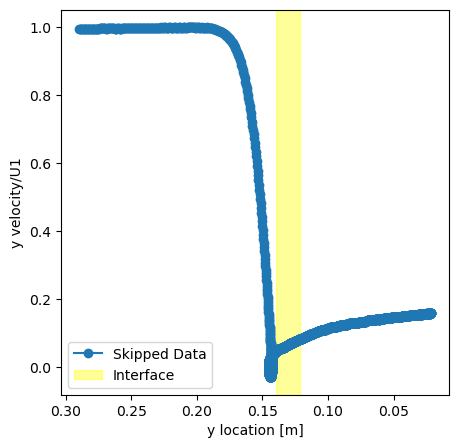

In [12]:
import matplotlib.patches as patches

# velocitys_meter = y_velocity_meter_cutted

fig, ax = plt.subplots(figsize=(8,8))
plt.plot(y_location_meter_cutted, y_velocity_meter_cutted, 'o-', label='Skipped Data')
plt.fill_between(y_location_meter_cutted, y_velocity_meter_cutted + wanted_velocity_uncertainty, y_velocity_meter_cutted - wanted_velocity_uncertainty, color='red', alpha=0.2, label='95% certainty')



# Interface
rect_x = Interface_center-Interface_thickness/2 #[m]
rect_width = Interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)


ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity [m/s]')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(y_location_meter_cutted, -y_velocity_meter_cutted/max(postivie_vel), 'o-', label='Skipped Data')


# Interface
rect_x = Interface_center-Interface_thickness/2 #[m]
rect_width = Interface_thickness
rect_y = ax.get_ylim()[0]  # Start from y=0
rect_height = ax.get_ylim()[1] - rect_y # Cover the entire y-axis range
rect_patch = patches.Rectangle((rect_x, rect_y), rect_width, rect_height, alpha=0.4, color='yellow', label='Interface')
ax.add_patch(rect_patch)


ax.set_xlabel('y location [m]')
ax.set_ylabel('y velocity/U1')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

Load Data from excel

In [13]:
Mf.display_images_with_points_napari(pic_folder, sphere_location_pixel, title = 'Verify sphere location')

2767

In [14]:
run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
density_by_row = [1095.65,1096.65,1097.05,1099.95,1101.25,1102.55,1108.5,1111.5]
diameter_by_row = [10.04025,10.03325,10.04025,10.04225,10.03425,10.03775,10.03825,10.03775]

sphere_diameter = diameter_by_row[run_number-1]/1000
calculated_sphere_rho = density_by_row[run_number-1]

In [15]:
from scipy.constants import g
upper_velocity = -min(y_velocity_meter_cutted)
lower_velocity = -y_velocity_meter_cutted[-1]
min_velocity = -max(y_velocity_meter_cutted)

upper_Re = upper_velocity*sphere_diameter/upper_viscosity
lower_Re = lower_velocity*sphere_diameter/lower_viscosity
Brunt_number = np.sqrt(2*g/Interface_thickness*(lower_density-upper_density)/(lower_density+upper_density))
upper_Fr = upper_velocity/(Brunt_number*sphere_diameter)
lower_Fr = lower_velocity/(Brunt_number*sphere_diameter)

New minimum

In [16]:
postivie_vel = -y_velocity_meter_cutted
if postivie_vel[-1] - wanted_velocity_uncertainty - min(postivie_vel) + wanted_velocity_uncertainty <= wanted_velocity_uncertainty:
    print ('Uncertainty Zone')

if min(postivie_vel)<0:
    state = 'bouncing'
elif postivie_vel[-1] - wanted_velocity_uncertainty > min(postivie_vel) + wanted_velocity_uncertainty:
    state = 'minimum'
else:
    state = 'no - minimum'
print(state)

bouncing


In [17]:
run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
print(f'''experiment_date = {experiment_date}
Experiment Number {experiment_number}
run_number = {run_number}
sphere_type = {sphere_type}
sphere_diameter = {sphere_diameter}
sphere_rho = {sphere_rho}
upper_density = {upper_density}
lower_density = {lower_density}
upper_viscosity = {upper_viscosity}
lower_viscosity = {lower_viscosity}
calculated sphere density = {calculated_sphere_rho}
upper_Re = {upper_Re}
lower_Re = {lower_Re}
upper_Fr = {upper_Fr}
lower_Fr = {lower_Fr}
Brunt_number = {Brunt_number}
state = {state}''')

experiment_date = 2024/2/22
Experiment Number 1
run_number = 1
sphere_type = P2
sphere_diameter = 0.01004025
sphere_rho = 1110
upper_density = 1086.0
lower_density = 1096.0
upper_viscosity = 2.8929999999999997e-06
lower_viscosity = 3.476733333333333e-06
calculated sphere density = 1095.65
upper_Re = 126.96338198355785
lower_Re = 16.780966802991063
upper_Fr = 1.6305200837661271
lower_Fr = 0.2589927435300023
Brunt_number = 2.2346613104041357
state = bouncing


In [18]:
run_number = int(os.path.splitext(Mf.files_in_folder(pic_folder, 'cihx')[0])[0][-2:])
# dimensionless_numbers_path_excel = os.path.join(parent_folder, 'Dimensionless Numbers PTV.xlsx')


dimensionless_numbers_path_excel = '..\\Excel Files\\Dimensionless Numbers PTV.xlsx'
xls = pd.ExcelFile(dimensionless_numbers_path_excel)
selected_sheet_name = xls.sheet_names[0]
df = pd.read_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name)

new_data = {'Data Processing Date': datetime.date.today().strftime("%Y/%m/%d"), 'Data Processing Hour': datetime.datetime.now().strftime("%H:%M:%S"),
            'Experiment Date': experiment_date, 'Record number': run_number, 'Sphere Type': sphere_type, 'Experiment number': experiment_number,
            'Sphere Diameter [m]': sphere_diameter, 'Sphere density [kg/m^3]': sphere_rho, 'Upper density [kg/m^3]': upper_density,
            'Lower density [kg/m^3]': lower_density, 'Upper viscosity [m^2/sec]': upper_viscosity, 'Lower viscosity [m^2/sec]': lower_viscosity,
            'Upper velocity [m/s]': upper_velocity, 'Lower velocity [m/s]': lower_velocity,'Minimum velocity [m/s]': min_velocity,
            'Upper Re': upper_Re, 'Lower Re': lower_Re, 'Upper Fr': upper_Fr, 'Lower Fr': lower_Fr, 'Brunt Number': Brunt_number, 'State': state,
            'Calculated sphere density [kg/m^3]': calculated_sphere_rho, 'Interface width [m]': Interface_thickness,
            'Full Trajectory Time [sec]': len(Mf.find_pictures(pic_folder))/frames_per_second, 'Index': len(df),
            'Vertical Location For Velocity [m] list':np.array(y_location_meter_cutted).tolist(),
            'Velocity Times [sec] list' : np.array(y_times_cutted).tolist(),
            'Velocity [m/s] list': np.array(y_velocity_meter_cutted).tolist(),
            'Solution': 'Water - Glycerol', 'Notes': 'precision experiment - manual',
            'First Frame': t_0_frame, 'Frames Per Second': frames_per_second, 'Scaling Factor': scaling_factor, 'Note' : 'Manually'}

df.loc[len(df)] = new_data
df.to_excel(dimensionless_numbers_path_excel, sheet_name=selected_sheet_name, index=False)
xls.close()

print(f'The file {os.path.basename(dimensionless_numbers_path_excel)} has been updated at: {os.path.dirname(dimensionless_numbers_path_excel)}')

The file Dimensionless Numbers PTV.xlsx has been updated at: C:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Shared Folder\Excel Files


In [19]:
new_pickle_data = new_data.copy()
new_column = np.arange(t_0_frame, t_0_frame + len(sphere_location_meter))
sphere_location_meter_with_frame = np.hstack((new_column.reshape(-1, 1), sphere_location_meter))
sphere_location_pixel_with_frame = np.hstack((new_column.reshape(-1, 1), sphere_location_pixel))

new_pickle_data['Sphere Locations'] = sphere_location_meter_with_frame
new_pickle_data['Sphere Locations Pixel'] = sphere_location_pixel_with_frame

In [20]:
pickle_location = '..\\Excel Files\\The Big Pickle.pkl'
The_big_pickle = Mf.load_pickle(pickle_location)

The_big_pickle[f'Experiment Date {experiment_date} Experiment Number {experiment_number} Record Number {run_number}'] = new_pickle_data
Mf.save_pickle(pickle_location, The_big_pickle)

The file "The Big Pickle.pkl" has been saved at: C:\Users\Morten\OneDrive - mail.tau.ac.il\Thesis\Shared Folder\Excel Files
